<a href="https://colab.research.google.com/github/SherbyRobotics/pyro/blob/colab/examples/notebooks/2DoF_robot_arm_kinematic_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Robot arm kinematic control

This page introduce the concept of controlling the end-effector of a robot when its joint are controlled with velocity set-points.

## Importing Librairies

In [5]:
# Loading a robotic toolbox
!git clone https://github.com/SherbyRobotics/pyro
import sys
sys.path.append('/content/pyro')
import pyro

# Generic python tools
import numpy as np
from IPython import display

fatal: destination path 'pyro' already exists and is not an empty directory.


# Defining the robot arm

Here we load a already defined class from the library including the dynamic equations defining the robot arm behavior.



In [6]:
from pyro.dynamic import manipulator

# Dynamic model (inputs are motor torques)
torque_controlled_robot    = manipulator.TwoLinkManipulator()

# Kinematic only model (inputs are motor velocities)
speed_controlled_robot  = manipulator.SpeedControlledManipulator.from_manipulator( torque_controlled_robot )

robot = speed_controlled_robot # For this exercise, we will only use the kinematic model

The properties like the lenght of the two links can be modified here:

In [7]:
robot.l1 = 0.5 # length of first rigid link
robot.l2 = 0.3 # length of second rigid link

## Showing the robot behavior with constant velocity inputs

Here we run a simulation of the robot arm with no controllers:

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


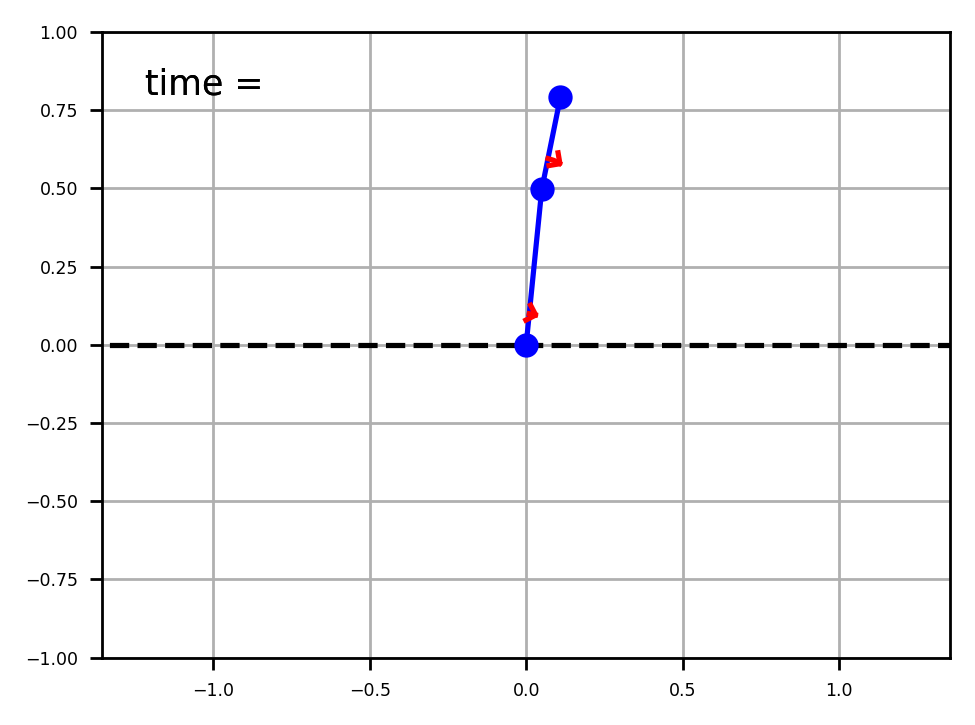

In [8]:
# robot initial states [ joint 1 angle (rad),  joint 2 angle (rad), joint 1 velocity (rad/sec),  joint 1 velocity (rad/sec)]
robot.x0 = np.array([ 0.1, 0.1]) 

# robot constant inputs
robot.ubar = np.array([ 0.5, 1.0]) # Constant joint velocities

# run the simulation
robot.compute_trajectory( tf = 6 )

# Animate and display the simulation
robot.animate_simulation()
#ani  = robot.generate_simulation_html_video()
#html = display.HTML( ani )
#display.display(html)

# Kinematic controller

Here bellow you can write your own custom kinematic control law, i.e. computing the joint velocity based on actual joint position and time. Here the framework is already set in place for you to speed-up the implementation process. The following variable are pre-computed and available for you to use in the feedback law:

*   The joint angles $q$ 
*   The time $t$

Furthermore, based on a kinematic robot model the following properties are also pre-computed:
*   The actual end-effector position $r$
*   The Jacobian $J(q)$



In [9]:
from pyro.control  import robotcontrollers

class CustomKinematicController( robotcontrollers.EndEffectorKinematicController ) :

    #############################
    def c( self , y , r , t ):
        """ 
        Feedback static computation u = c(y,r,t)
        
        INPUTS
        y  : sensor signal vector     p x 1
        r  : reference signal vector  k x 1
        t  : time                     1 x 1
        
        OUTPUTS
        dq  : joint velocity vector   m x 1
        
        """

        # Feedback from sensors
        q = y                  # Joint angles
        
        # Pre-computed values based on the robot kinematic model
        J = self.J( q )        # Jacobian computation
        r = self.fwd_kin( q )  # End-effector postion

        ##############################
        # YOUR CODE BELLOW !!
        ##############################

        # Compute the reference
        r_d  = np.zeros(2) # Place-holder
        dr_d = np.zeros(2) # Place-holder

        # Compute the desired effector velocity 
        dr_r = np.array([-0.1,0.1]) # Place holder
        
        # From effector speed to joint speed
        dq = np.linalg.inv( J ) @ dr_r 
        
        return dq

In [10]:
ctl = CustomKinematicController( robot )

## Simulating the robot in closed-loop

Here we run a simulation of the robot with the controller.

In [11]:
# Create the closed-loop system
robot_with_controller = ctl + robot

# Run the simulation
robot_with_controller.x0[0] = 1.0
robot_with_controller.x0[1] = 1.0
robot_with_controller.compute_trajectory( tf = 3 )

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


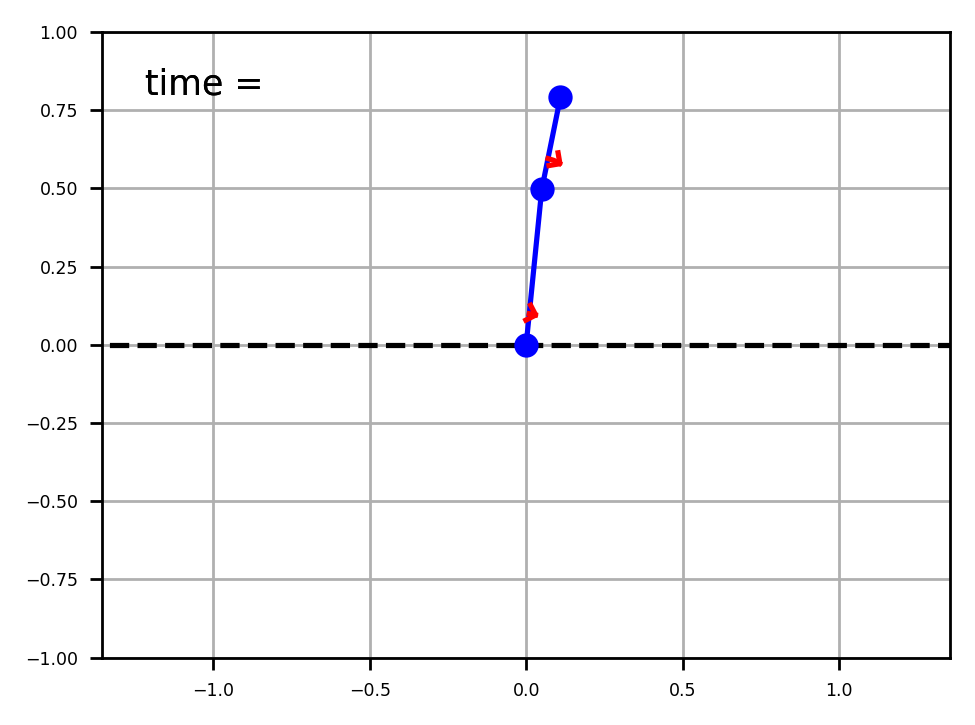

In [12]:
# Animate the simulation
robot.animate_simulation()
#ani = robot_with_controller.generate_simulation_html_video()
#html = display.HTML(ani)
#display.display(html)

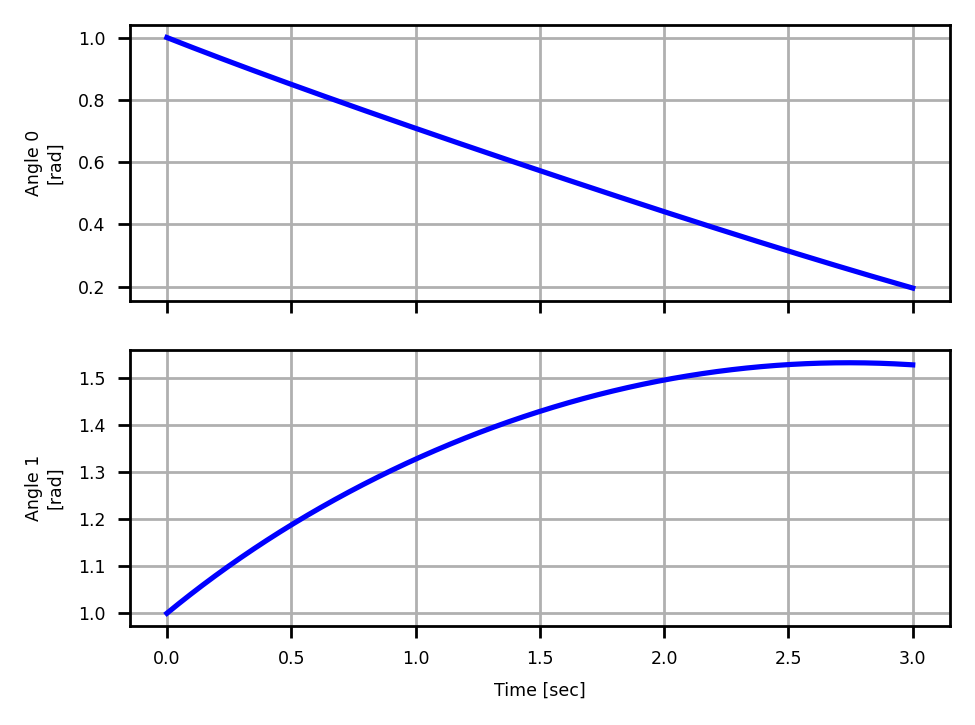

(<Figure size 1000x750 with 2 Axes>,
 array([<Axes: ylabel='Angle 0\n[rad]'>,
        <Axes: xlabel='Time [sec]', ylabel='Angle 1\n[rad]'>], dtype=object),
  <matplotlib.lines.Line2D at 0x22166946990>])

In [13]:
# Plot systems states
robot_with_controller.plot_trajectory('x')

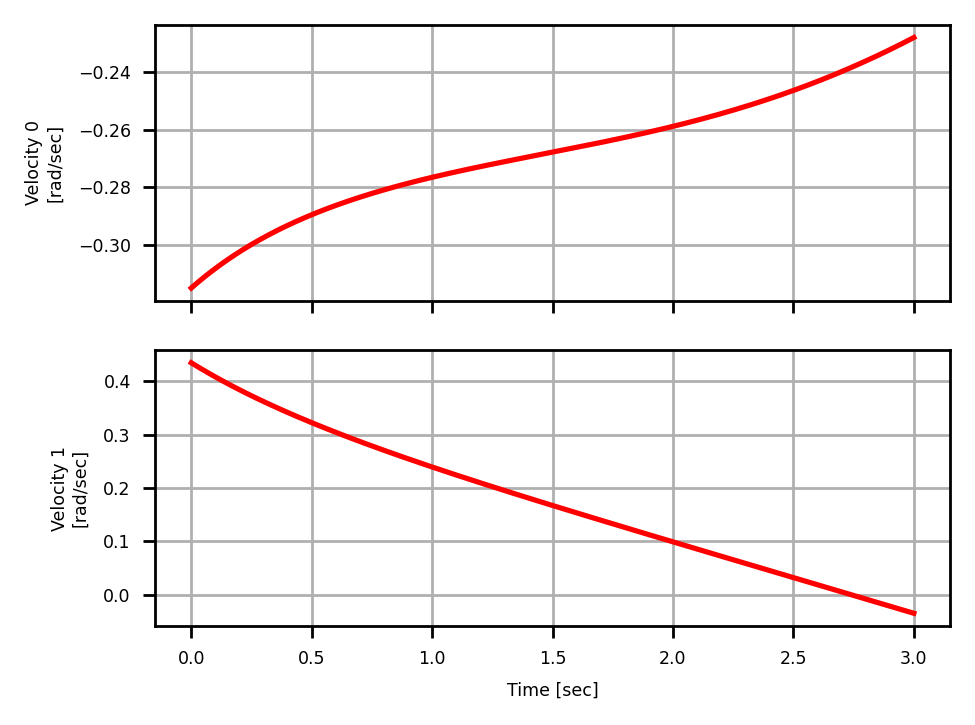

(<Figure size 1000x750 with 2 Axes>,
 array([<Axes: ylabel='Velocity 0\n[rad/sec]'>,
        <Axes: xlabel='Time [sec]', ylabel='Velocity 1\n[rad/sec]'>],
       dtype=object),
  <matplotlib.lines.Line2D at 0x22166fe6c10>])

In [14]:
# Plot control inputs
robot_with_controller.plot_trajectory('u')